In [2]:
import sys
from pathlib import Path

BASE_PATH = Path().resolve().parent
# Dynamically add 'src' folder to the PYTHONPATH
sys.path.append(str(BASE_PATH / 'src'))

In [6]:
import os
import json
import pickle

from pychomsky.chchat import EbayLLMChatWrapper


from config import EMBEDDER_MODELS
from docindex import DocIndex

In [7]:
EMBEDDER_MODELS


{'MPNet-V2': {'model_name': 'sentence-transformers/all-mpnet-base-v2',
  'index_path': 'demos/demo_v0/resources/indexes/mpnet_index.pkl',
  'chunk_size': 384},
 'Vector-Prime': {'model_name': 'EBAY_INTERNAL_VECTOR_PRIME',
  'index_path': 'demos/demo_v0/resources/indexes/vector_prime_index.pkl',
  'chunk_size': 384}}

In [1]:
print("\u2018")

‘


In [9]:
selller_center_data = os.path.join(BASE_PATH, "demos/demo_v0/resources/content/sellercenter_crawled_data.json")

# Open and read the JSON file
with open(selller_center_data, 'r') as file:
    documents = json.load(file)


In [10]:
llm = EbayLLMChatWrapper(
        model_name="openai-chat-completions-gpt-4o-mini-2024-07-18",
        temperature=0.5,
        max_tokens=2048
    )

In [11]:
synthetic_question_prompt = """
You are provided with the following content:

`{{text}}`

Your task is to generate a list of up to 5 potential user questions and their corresponding answers based on the content. Follow these guidelines:

1. Ensure all questions and answers are derived strictly from the provided content and do not introduce information that is not explicitly present in the content.
2. Ensure the questions cover a range of topics present in the content.
3. Include questions with varying levels of complexity, from simple to more detailed.
4. Make the questions relevant to the main purpose or subject of the content.
5. Phrase the questions as direct queries that a user might naturally ask.
6. Do not number the questions or include an index before them.
7. Focus on creating reasonable, specific questions that a seller might ask if applicable.
8. If the content does not support generating 5 questions, produce fewer instead.
9. Provide answers that are directly and accurately derived from the provided content.

### Output Format:
Your answers should be in JSON format only, following this structure:

[
    {
        "question": "Example question?",
        "answer": "Example answer."
    },
    {
        "question": "Another question?",
        "answer": "Another answer."
    }
]

Do not include any explanations, code fences, or additional text before or after the JSON data.
"""

In [12]:
import time
import random

def retry_with_backoff(
    func,
    args=None,
    kwargs=None,
    max_retries=3,
    base_sleep=2,
    exceptions=(Exception,),
    skip_retry_exceptions=(json.JSONDecodeError,),
):
    """
    A generic retry mechanism with exponential backoff and jitter.

    Args:
        func (callable): The function to retry.
        args (tuple): Positional arguments to pass to the function.
        kwargs (dict): Keyword arguments to pass to the function.
        max_retries (int): Maximum number of retries.
        base_sleep (int): Base sleep time for exponential backoff.
        exceptions (tuple): Tuple of exception types to retry on.

    Returns:
        Any: The result of the function if it succeeds.

    Raises:
        Exception: The last exception if all retries fail.
    """
    args = args or ()
    kwargs = kwargs or {}
    retries = 0

    while retries <= max_retries:
        try:
            # Attempt the function call
            return func(*args, **kwargs)
        except skip_retry_exceptions as e:
            print(e)
            retries += 1
            if retries > max_retries:
                return None
        except exceptions as e:
            print(e)
            retries += 1
            if retries > max_retries:
                return None
            
            # Exponential backoff with jitter
            sleep_time = base_sleep * (2 ** retries) + random.uniform(0, 1)
            print(f"Retrying ({retries}/{max_retries}) after {sleep_time:.2f} seconds due to: {e}")
            time.sleep(sleep_time)

In [434]:
import re
import json

def generate_questions(prompt, text):
    """
    Generate questions using an LLM call.
    """
    formatted_prompt = prompt.replace("{{text}}", text)
    messages = [
        {"role": "system", "content": "You are a helpful assistant that generates questions."},
        {"role": "user", "content": formatted_prompt}
    ]

    # Define the function to call the LLM
    def llm_call():
        response = llm.invoke(messages)  # Replace `llm.invoke` with your actual API call
        return extract_json(response.content)

    # Use the generic retry mechanism
    return retry_with_backoff(
        llm_call,
        max_retries=1,
        base_sleep=30,
        exceptions=(Exception,),
        skip_retry_exceptions=(json.JSONDecodeError,)
    )
                              

def extract_json(content):
    """
    Extracts and parses JSON data from the response content.
    """
    try:
        # print(content)
        # # Match JSON enclosed in ```json ... ```
        # json_match = re.search(r"json(.*?)", content, re.DOTALL)
        # if json_match:
        #     json_str = json_match.group(1).strip()
        # else:
        #     json_str = content.strip()

        # # Replace single quotes with double quotes
        # json_str = json_str.replace("'", "\"")
        return json.loads(content)
    except json.JSONDecodeError as jde:
        print(jde)
        # Raise JSONDecodeError for proper exception handling
        raise json.JSONDecodeError(msg=str(jde), doc=content, pos=0)
    except Exception as e:
        print(e)
        # Wrap other exceptions as JSONDecodeError for consistency
        raise json.JSONDecodeError(msg=f"Unexpected error: {e}", doc=content, pos=0)

In [435]:
generate_questions(str(synthetic_question_prompt), documents[8]["content"])

[{'question': 'How can I keep my buyers informed about their order status?',
  'answer': 'You can keep your buyers informed by setting accurate handling times and uploading tracking information before the estimated delivery date has passed.'},
 {'question': 'Why is having a generous returns policy important for my sales?',
  'answer': 'Offering a generous return policy makes shoppers more confident in their purchase, which can lead to increased sales and a competitive edge over other sellers.'},
 {'question': 'What should I include in my product listings to avoid customer dissatisfaction?',
  'answer': 'You should write a clear description and include well-shot photos to ensure buyers know what to expect from their order.'},
 {'question': 'How can I prevent issues with unpaid items?',
  'answer': 'You should require immediate payment for both fixed-price and auction-style listings with a Buy It Now option to avoid disputes with buyers.'},
 {'question': 'Where can I manage requests and 

In [436]:
import time
def generate_synthetic_questions(documents, output_file):
    questions = []
    visited_urls = set()
    if os.path.exists(output_file):
        with open(output_file, 'r') as json_file:
            questions = json.load(json_file)
            visited_urls = set([q['url'] for q in questions])
            print(f"load #{len(visited_urls)} documents")
        
    for doc in documents:
        url = doc["url"]
        if url not in visited_urls:
            try:
                qs = generate_questions(str(synthetic_question_prompt), doc["content"])

                if qs:
                    questions += [{
                        "question": q["question"],
                        "question": q["answer"],
                        "answer": url
                        
                    } for q in qs]
                    visited_urls.add(url)

                    
            except Exception as e:
                print(e)
        

    with open(output_file, 'w') as json_file:
        json.dump(questions, json_file, indent=4)

    return questions, visited_urls

In [437]:
data_path = os.path.join(BASE_PATH, "./data")
sellercenter_question_file = os.path.join(data_path, "sellercenter_question.json")
questions, visited_urls = generate_synthetic_questions(documents, sellercenter_question_file)

load #136 documents


### Retrieval Evaluation

In [463]:
import os
from collections import defaultdict

class DocumentRetrievalEvaluator:
    def __init__(self, base_path, document_path, model_name='MPNet-V2', question_emb_cach_path=None):
        """
        Initialize the evaluator.
        
        :param base_path: Base directory for index and content files.
        :param embedder_model: Dictionary containing embedder model details (name, index_path).
        :param top_ks: List of top-k values for evaluation.
        """
        self.base_path = base_path
        self.model_name = model_name
        self.index_path = os.path.join(base_path, EMBEDDER_MODELS[model_name]['index_path'])
        self.embeder_mdoel_name = EMBEDDER_MODELS[model_name]["model_name"]
        
        self._build_index(document_path)

        if question_emb_cach_path:
            print("load cached question ebedding from ", question_emb_cach_path)
            with open(question_emb_cach_path, "rb") as f:
                self.question_embedding_cache  = pickle.load(f)
        else:
            self.question_embedding_cache = {}

    def _build_index(self, content_path):
        """
        Build the document index.
        
        :param content_path: Path to the JSON content file for building the index.
        """
        self.d = DocIndex(index_path=self.index_path)
        self.d.build(
            content_path=content_path,
            index_path=self.index_path,
            embedder_model_name=self.embeder_mdoel_name
        )

    def search(self, question, top_k):
        """
        Search the index for a given question.
        
        :param question: The question string.
        :param top_k: The number of top results to retrieve.
        :return: Tuple of (question, retrieved URLs).
        """
        # return self.d.search(question=question, top_k=top_k, question_embeddings=question_embedding_cache)
    
        if question not in self.question_embedding_cache:
            query_embedding = self.d.embedder.generate_embedding(question)
            query_embedding = query_embedding.reshape(1, -1)
            self.question_embedding_cache[question] = query_embedding
        else:
            query_embedding = self.question_embedding_cache[question]

        # Perform search in the FAISS index
        _, indices = self.d.index.search(query_embedding, top_k)

        return [self.d.urls[i] for i in indices[0]]

    def evaluate(self, questions, top_k):
        """
        Evaluate the retrieval performance for given questions.
        
        :param questions: List of dictionaries containing 'url' and 'question'.
        :return: Dictionary of hit counts for each top_k value.
        """
        hit_cnt = defaultdict(int)
        for question in questions:
            gt_url = question["url"]
            q = question["question"]
            recall_urls = self.search(question=q, top_k=top_k)

            
            hits = [0] * (top_k+1)
            for idx, url in enumerate(recall_urls):
                if url == gt_url:
                    hits[idx + 1] = 1
                else:
                    hits[idx + 1] = hits[idx]

                hit_cnt[idx+1] += hits[idx + 1]


        return hit_cnt

    def display_results(self, hit_cnt, total_questions):
        """
        Display the evaluation results.
        
        :param hit_cnt: Dictionary of hit counts.
        :param total_questions: Total number of questions evaluated.
        """
        for k, hits in hit_cnt.items():
            percentage = hits / total_questions * 100
            print(f"Hit@{k}: {hits}/{total_questions} ({percentage:.2f}%)")



#### MPNet-V2

In [464]:
document_path = "demos/demo_v0/resources/crawl_data/sellercenter_crawled_data.json"
model_name = "MPNet-V2"
evaluator = DocumentRetrievalEvaluator(base_path=BASE_PATH,
                           document_path=document_path,
                           model_name=model_name)

Loading index from /Users/wliu7/projects/python/how-to-agent/demos/demo_v0/resources/crawl_data//mpnet_index.pkl
Index exists at /Users/wliu7/projects/python/how-to-agent/demos/demo_v0/resources/crawl_data//mpnet_index.pkl


In [454]:
eval_questions[0]["question"]

"What are the benefits of using eBay's Authenticity Guarantee for selling sneakers?"

In [455]:
eval_questions[0]["url"]

'https://www.ebay.com/sellercenter/selling/selling-sneakers'

In [458]:
evaluator.search(eval_questions[0]["question"], top_k=5)

['https://www.ebay.com/sellercenter/selling/selling-sneakers',
 'https://www.ebay.com/help/buying/buying-authenticity-guarantee/buying-authenticity-guarantee?id=5470',
 'https://www.ebay.com/help/selling/selling-tools/selling-authenticity-guarantee?id=4644',
 'https://www.ebay.com/help/buying/buying-authenticity-guarantee/buying-authenticity-guarantee?id=5470',
 'https://www.ebay.com/sellercenter/selling/selling-sneakers']

In [444]:
eval_questions  = [{
    "question": q["question"],
    "url": q["url"]
}
for q in questions]

In [465]:
eval_questions 
standard_mp_net_hit_counts = evaluator.evaluate(questions=eval_questions, top_k=5)
evaluator.display_results(hit_cnt=standard_mp_net_hit_counts, total_questions=len(eval_questions))


Hit@1: 319/680 (46.91%)
Hit@2: 378/680 (55.59%)
Hit@3: 409/680 (60.15%)
Hit@4: 440/680 (64.71%)
Hit@5: 465/680 (68.38%)


In [426]:
eval_questions 
standard_mp_net_hit_counts = evaluator.evaluate(questions=eval_questions)
evaluator.display_results(hit_cnt=standard_mp_net_hit_counts, total_questions=len(eval_questions))


Hit@1: 319/680 (46.91%)
Hit@2: 378/680 (55.59%)
Hit@3: 409/680 (60.15%)
Hit@4: 440/680 (64.71%)
Hit@5: 465/680 (68.38%)


#### Vector-Prime 

In [236]:
document_path = "demos/demo_v0/resources/crawl_data/sellercenter_crawled_data.json"
sellcenter_q_emb_path = os.path.join(BASE_PATH, "data/sellcenter_q_vp_emb.pkl")
model_name = "Vector-Prime"
vp_evaluator = DocumentRetrievalEvaluator(base_path=BASE_PATH,
                           document_path=document_path,
                           model_name=model_name,
                           top_ks=[1, 2, 3, 4, 5],
                           question_emb_cach_path=sellcenter_q_emb_path)

Loading index from /Users/wliu7/projects/python/how-to-agent/demos/demo_v0/resources/crawl_data//vector_prime_index.pkl
Index exists at /Users/wliu7/projects/python/how-to-agent/demos/demo_v0/resources/crawl_data//vector_prime_index.pkl
load cached question ebedding from  /Users/wliu7/projects/python/how-to-agent/data/sellcenter_q_vp_emb.pkl


In [239]:
vp_hit_counts = vp_evaluator.evaluate(questions=eval_questions)
vp_evaluator.display_results(hit_cnt=vp_hit_counts, total_questions=len(eval_questions))


Hit@1: 362/680 (53.24%)
Hit@2: 434/680 (63.82%)
Hit@3: 467/680 (68.68%)
Hit@4: 498/680 (73.24%)
Hit@5: 521/680 (76.62%)


#### Summarization

##### Hit@K

In [384]:
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    "K Value": list(standard_mp_net_hit_counts.keys()),
    "MPNet-V2 Hits": list(standard_mp_net_hit_counts.values()),
    "Vector-Prime Hits": list(vp_hit_counts.values())
})

df['MPNet-V2 Hit Rate'] = df['MPNet-V2 Hits'] / len(questions)
df['Vector-Prime Rate'] = df['Vector-Prime Hits'] / len(questions)

df


,K Value,MPNet-V2 Hits,Vector-Prime Hits,MPNet-V2 Hit Rate,Vector-Prime Rate
0,1,379,362,0.557353,0.532353
1,2,441,434,0.648529,0.638235
2,3,484,467,0.711765,0.686765
3,4,496,498,0.729412,0.732353
4,5,512,521,0.752941,0.766176


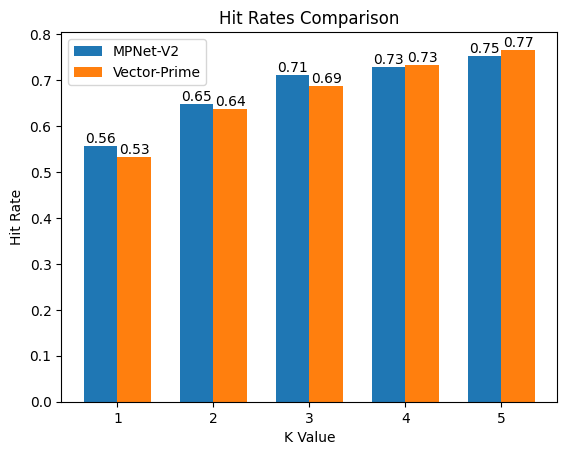

In [385]:
import matplotlib.pyplot as plt
import numpy as np

# Bar plot for hit rates
x = df["K Value"]
width = 0.35  # Width of the bars

# Create the bar chart
bar1 = plt.bar(x - width/2, df["MPNet-V2 Hit Rate"], width, label="MPNet-V2")
bar2 = plt.bar(x + width/2, df["Vector-Prime Rate"], width, label="Vector-Prime")

# Adding labels to each bar
for bar in bar1:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate of the bar center
        bar.get_height(),                  # Y-coordinate of the bar height
        f'{bar.get_height():.2f}',         # Text (hit rate value)
        ha='center', va='bottom', fontsize=10  # Alignment and font size
    )

for bar in bar2:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.2f}',
        ha='center', va='bottom', fontsize=10
    )

# Adding labels and title
plt.xlabel("K Value")
plt.ylabel("Hit Rate")
plt.title("Hit Rates Comparison")
plt.xticks(x)
plt.legend()

# Show plot
plt.show()


In [412]:
normal_questions = [{
                        "question": q["question"]["question"],
                        "answer": q["question"]["answer"],
                        "url": q["url"]
                        
                    } for q in questions]

In [414]:
sellercenter_question_file = os.path.join(data_path, "sellercenter_question1.json")
with open(sellercenter_question_file, 'w') as json_file:
    json.dump(normal_questions, json_file, indent=4)

#### mAP

In [255]:
def cacaluate_map(hit_counts, total_cnt):
    k = max(hit_counts.values())

    hit_in_k = [0]*(k+1)
    for idx, count in hit_counts.items():
        hit_in_k[idx] = count

    for i in range(5, 0, -1):
        hit_in_k[i] = hit_in_k[i] - hit_in_k[i-1]

    map = sum([hit_in_k[i] * 1/i for i in range(1, k+1)])/total_cnt
    return map

mp_net_mAP = cacaluate_map(mp_net_hit_counts, len(eval_questions))
vp_net_mAP = cacaluate_map(vp_hit_counts, len(eval_questions))

print(f"recall mAP (MPNet-V2): {mp_net_mAP:.4f}")
print(f"recall mAP (Vector-Prime): {vp_net_mAP:.4f}")


recall mAP (MPNet-V2): 0.6331
recall mAP (Vector-Prime): 0.6196


### Question Extension

In [347]:
variant_question_prompts = """
You are tasked with generating diverse variants of a given question to simulate how different users might ask it.

### Instructions:
1. Ensure all variants preserve the original meaning of the question.
2. Use the following techniques for diversity:
   - **Synonym Substitution**: Replace words with synonyms or similar expressions.
   - **Sentence Structure Change**: Reorganize the sentence while retaining its meaning.
   - **Question Type Variation**: Alter the question format (e.g., interrogative, declarative).
   - **Informal Language**: Add typos, slang, or casual phrasing.
3. Return exactly 5 distinct variants of the given question.
4. Output the results in a structured JSON format.

### Input:
`{{text}}`

### Output Format:
Your answers should be in JSON format only, following this structure:

{
    "original_question": "{{test}}",
    "variants": [
        "<First variant>",
        "<Second variant>",
        "<Third variant>",
        "<Fourth variant>",
        "<Fifth variant>"
    ]
}

Do not include any explanations, code fences, or additional text before or after the JSON data.

"""

In [427]:
import os
import json
import time

def generate_question_variants(questions, output_file):
    print(f"Start quetion variants generation fro #{len(questions)} questions")

    question_variants = []
    visited_questions = set()
    
    # If the file exists, load the existing questions
    if os.path.exists(output_file):
        with open(output_file, 'r') as json_file:
            question_variants = json.load(json_file)
            visited_questions = set([q['original_question'] for q in question_variants])
            print(f"Loaded #{len(visited_questions)} visited_questions")
    
    count = 0  # Counter to track the number of newly added questions

    for question in questions:
        q = question['question']
        if q not in visited_questions:
            variant_qs = generate_questions(str(variant_question_prompts), q)

            if variant_qs:
                variant_qs["url"] = question["url"]
                question_variants.append(variant_qs)
                visited_questions.add(q)
                count += 1  # Increment the counter for each new question added

                # Save to file every time the count reaches a multiple of 50
                if count % 20 == 0:
                    with open(output_file, 'w') as json_file:
                        json.dump(question_variants, json_file, indent=4)
                    print(f"Intermediate save: wrote #{len(visited_questions)} questions so far")

    # Final save at the end to ensure all questions are written to the file
    with open(output_file, 'w') as json_file:
        json.dump(question_variants, json_file, indent=4)
    print(f"Final save: wrote #{len(visited_questions)} questions")

    return question_variants, visited_questions


In [428]:
data_path = os.path.join(BASE_PATH, "./data")
sellercenter_question_variant_file = os.path.join(data_path, "sellercenter_question_variant.json")
question_variants, visited_questions = generate_question_variants(questions, sellercenter_question_variant_file)

Start quetion variants generation fro #680 questions
Loaded #675 visited_questions
Final save: wrote #675 questions


In [382]:
eval_variant_questions = []
for q in question_variants:
    variant_qs = [{
        "question": va,
        "url": q["url"]
    }
    for va in q["variants"]]

    eval_variant_questions += variant_qs
mp_net_hit_counts = evaluator.evaluate(questions=eval_variant_questions)
evaluator.display_results(hit_cnt=mp_net_hit_counts, total_questions=len(eval_variant_questions))

Hit@1: 1820/3375 (53.93%)
Hit@2: 2132/3375 (63.17%)
Hit@3: 2317/3375 (68.65%)
Hit@4: 2440/3375 (72.30%)
Hit@5: 2531/3375 (74.99%)


In [387]:
mp_net_hit_counts

defaultdict(int, {1: 1820, 2: 2132, 3: 2317, 4: 2440, 5: 2531})

In [388]:
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    "K Value": list(standard_mp_net_hit_counts.keys()),
    "Standard  Hits": list(standard_mp_net_hit_counts.values()),
    "Extended Hits": list(mp_net_hit_counts.values())
})

df['Standard'] = df['Standard  Hits'] / len(questions)
df['Extened'] = df['Extended Hits'] / len(eval_variant_questions)

df


,K Value,Standard Hits,Extended Hits,Standard,Extened
0,1,379,1820,0.557353,0.539259
1,2,441,2132,0.648529,0.631704
2,3,484,2317,0.711765,0.686519
3,4,496,2440,0.729412,0.722963
4,5,512,2531,0.752941,0.749926


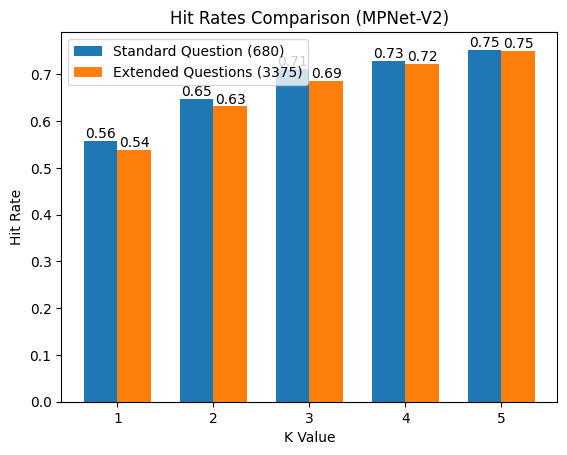

In [392]:
import matplotlib.pyplot as plt
import numpy as np

# Bar plot for hit rates
x = df["K Value"]
width = 0.35  # Width of the bars

# Create the bar chart
bar1 = plt.bar(x - width/2, df["Standard"], width, label=f"Standard Question ({len(questions)})")
bar2 = plt.bar(x + width/2, df["Extened"], width, label=f"Extended Questions ({len(eval_variant_questions)})")

# Adding labels to each bar
for bar in bar1:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate of the bar center
        bar.get_height(),                  # Y-coordinate of the bar height
        f'{bar.get_height():.2f}',         # Text (hit rate value)
        ha='center', va='bottom', fontsize=10  # Alignment and font size
    )

for bar in bar2:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.2f}',
        ha='center', va='bottom', fontsize=10
    )

# Adding labels and title
plt.xlabel("K Value")
plt.ylabel("Hit Rate")
plt.title("Hit Rates Comparison (MPNet-V2)")
plt.xticks(x)
plt.legend()

# Show plot
plt.show()


## Generate the synthetics question

In [287]:
questions

[{'question': {'question': "What are the benefits of using eBay's Authenticity Guarantee for selling sneakers?",
   'answer': 'The Authenticity Guarantee ensures physical authentication and verified returns at no cost to you, allowing you to sell with confidence.'},
  'url': 'https://www.ebay.com/sellercenter/selling/selling-sneakers'},
 {'question': {'question': 'How can I ship my Authenticity Guarantee-eligible sneakers for free?',
   'answer': 'Beginning in October, upon sale, you’ll receive a FedEx shipping label at no cost to ship your Authenticity Guarantee-eligible sneakers to an authentication center.'},
  'url': 'https://www.ebay.com/sellercenter/selling/selling-sneakers'},
 {'question': {'question': 'What is the required handling time for shipping to the authentication center?',
   'answer': 'You need to meet a new handling time requirement of 3 business days or less for shipping to the authentication center.'},
  'url': 'https://www.ebay.com/sellercenter/selling/selling-snea

In [359]:
from embedder import Embedder

In [361]:
ember = Embedder("EBAY_INTERNAL_VECTOR_PRIME")

In [381]:
v1 = ember.generate_embedding("david Liu")
v1.dot(v1)

28507.21937555032

In [393]:
v1.dot(v1)

28507.21937555032

In [399]:
v2.dot(v2)

28298.0210141107

In [398]:
v2 = ember.generate_embedding("hello world")

In [371]:
v2.dot(v2)

28507.21937555032

In [372]:
v4 = ember.generate_embedding("david hello")

In [373]:
v4.dot(v4)

27646.914832883896

In [402]:
a = np.array([22657.63,  21941.113, 21486.66,  21463.654, 21436.564])

In [404]:
a / 28507

array([0.79480935, 0.76967457, 0.75373277, 0.75292574, 0.75197544])